[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/Robot.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [0]:
# Installs
!pip install -U -q PyDrive

In [2]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
import re
from io import StringIO

Using TensorFlow backend.


In [0]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [0]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [0]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  f = drive.CreateFile({'id': pow_file[1]})
  content = f.GetContentString()
  dataIO = StringIO(content)
  df = pd.read_csv(dataIO, header=None, sep=' ')
  list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

# Utils
Helper functions.

In [0]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [0]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

In [0]:
def get_toy_data():
  # TOY DATA
  times_list = [(np.transpose(np.array(df_cut[0][[0]])), df_cut[1]) for df_cut in list_df_cut]
  times_long = [(np.transpose(times[0]), times[1]) for times in times_list if times[0].shape[1]>=max_length]
  times_no_labels = [times[0] for times in times_long]

  num_cat = 2
  # Generate first class of data
  cos_data = [np.cos(times) for times in times_no_labels]
  cos_y = [to_one_hot(0)] * len(cos_data)
  # Generate second class of data
  arccos_data = [np.arccos(np.cos(times)) for times in times_no_labels]
  arccos_y = [to_one_hot(1)] * len(arccos_data) 
  # Combine together
  toy_data = cos_data + arccos_data
  toy_x = np.stack(toy_data, axis=0)
  toy_y = np.array(cos_y + arccos_y)

  plt.plot(arccos_data[0])
  print(toy_x.shape, toy_y.shape)
  return toy_x, toy_y

# Model
Recurrent Neural Network model in Keras.

In [0]:
def get_model():
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.3))
  model.add(LSTM(128))
  model.add(Dropout(0.3))
  model.add(Dense(num_cat))
  model.add(Activation("softmax"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [0]:
# Split the biggest examples into separate sequences
max_length = 1000
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 25 #75
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [0]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]
# Pad the measurements with 0s from the beginning
#currents_pad = [np.transpose(sequence.pad_sequences(currents[0], maxlen=max_length, dtype='float64')) for currents in currents_list]

In [0]:
# Skip some timesteps
skip = 10
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [0]:
# Get training data into a numpy matrix
train_x = np.stack(currents_skip, axis=0)
# Get training labels
train_y = np.array([currents[1] for currents in currents_long])
train_y_labels = [from_one_hot(one_hot) for one_hot in train_y]

In [36]:
print(train_x.shape, train_y.shape)

(98, 100, 1) (98, 6)


# Experiment

In [65]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
_________________________________________________________________
activation_7 (Activation)    (None, 6)                 0         
Total params: 198,918
Trainable params: 198,918
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [67]:
history = model.fit(train_x, train_y, epochs = 800)

Epoch 1/800
98/98 [==============================] - 3s 28ms/step - loss: 1.7816 - acc: 0.1735
Epoch 2/800
98/98 [==============================] - 1s 10ms/step - loss: 1.8207 - acc: 0.1633
Epoch 3/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7577 - acc: 0.2347
Epoch 4/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7734 - acc: 0.2041
Epoch 5/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7934 - acc: 0.2143
Epoch 6/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7537 - acc: 0.1837
Epoch 7/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7608 - acc: 0.2551
Epoch 8/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7451 - acc: 0.2551
Epoch 9/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7443 - acc: 0.2449
Epoch 10/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7642 - acc: 0.2653
Epoch 11/800
98/98 [=============================

98/98 [==============================] - 1s 10ms/step - loss: 1.7356 - acc: 0.2755
Epoch 22/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7448 - acc: 0.2653
Epoch 23/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7395 - acc: 0.2653
Epoch 24/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7183 - acc: 0.2653
Epoch 25/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7442 - acc: 0.2653
Epoch 26/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7376 - acc: 0.2653
Epoch 27/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7120 - acc: 0.2755
Epoch 28/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7271 - acc: 0.2653
Epoch 29/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7148 - acc: 0.3061
Epoch 30/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7488 - acc: 0.2347
Epoch 31/800
98/98 [==============================] -

98/98 [==============================] - 1s 10ms/step - loss: 1.7319 - acc: 0.1939
Epoch 42/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7336 - acc: 0.2857
Epoch 43/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7279 - acc: 0.2653
Epoch 44/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7322 - acc: 0.2551
Epoch 45/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7123 - acc: 0.2653
Epoch 46/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7213 - acc: 0.2551
Epoch 47/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7018 - acc: 0.2959
Epoch 48/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6959 - acc: 0.2755
Epoch 49/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7312 - acc: 0.2653
Epoch 50/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7221 - acc: 0.2653
Epoch 51/800
98/98 [==============================] -

98/98 [==============================] - 1s 10ms/step - loss: 1.6825 - acc: 0.2857
Epoch 62/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6733 - acc: 0.3061
Epoch 63/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7126 - acc: 0.2041
Epoch 64/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6793 - acc: 0.3469
Epoch 65/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7270 - acc: 0.2143
Epoch 66/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6475 - acc: 0.3367
Epoch 67/800
98/98 [==============================] - 1s 11ms/step - loss: 1.6638 - acc: 0.3469
Epoch 68/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6615 - acc: 0.2857
Epoch 69/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6509 - acc: 0.3367
Epoch 70/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6229 - acc: 0.3265
Epoch 71/800
98/98 [==============================] -

98/98 [==============================] - 1s 10ms/step - loss: 1.6849 - acc: 0.2857
Epoch 82/800
98/98 [==============================] - 1s 11ms/step - loss: 1.6321 - acc: 0.3265
Epoch 83/800
98/98 [==============================] - 1s 11ms/step - loss: 1.6268 - acc: 0.3265
Epoch 84/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5848 - acc: 0.3469
Epoch 85/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5942 - acc: 0.3061
Epoch 86/800
98/98 [==============================] - 1s 11ms/step - loss: 1.6782 - acc: 0.2857
Epoch 87/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6039 - acc: 0.3673
Epoch 88/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6250 - acc: 0.2755
Epoch 89/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6783 - acc: 0.2551
Epoch 90/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5605 - acc: 0.3878
Epoch 91/800
98/98 [==============================] -

98/98 [==============================] - 1s 10ms/step - loss: 1.5303 - acc: 0.3367
Epoch 102/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5336 - acc: 0.3367
Epoch 103/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7439 - acc: 0.3367
Epoch 104/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5152 - acc: 0.3673
Epoch 105/800
98/98 [==============================] - 1s 11ms/step - loss: 1.4421 - acc: 0.4286
Epoch 106/800
98/98 [==============================] - 1s 11ms/step - loss: 1.7397 - acc: 0.2857
Epoch 107/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4868 - acc: 0.4082
Epoch 108/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4762 - acc: 0.3980
Epoch 109/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4828 - acc: 0.3367
Epoch 110/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4641 - acc: 0.3571
Epoch 111/800
98/98 [=======================

Epoch 121/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4172 - acc: 0.4592
Epoch 122/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5337 - acc: 0.3265
Epoch 123/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4184 - acc: 0.3980
Epoch 124/800
98/98 [==============================] - 1s 11ms/step - loss: 1.3523 - acc: 0.4490
Epoch 125/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7067 - acc: 0.3163
Epoch 126/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4184 - acc: 0.3878
Epoch 127/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3604 - acc: 0.3673
Epoch 128/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5098 - acc: 0.3571
Epoch 129/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3866 - acc: 0.4184
Epoch 130/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5269 - acc: 0.3673
Epoch 131/800
98/98 [=========

Epoch 141/800
98/98 [==============================] - 1s 10ms/step - loss: 1.7129 - acc: 0.3163
Epoch 142/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3297 - acc: 0.4490
Epoch 143/800
98/98 [==============================] - 1s 11ms/step - loss: 1.2705 - acc: 0.5102
Epoch 144/800
98/98 [==============================] - 1s 11ms/step - loss: 1.2428 - acc: 0.5102
Epoch 145/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5523 - acc: 0.3878
Epoch 146/800
98/98 [==============================] - 1s 11ms/step - loss: 1.2285 - acc: 0.5204
Epoch 147/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5099 - acc: 0.3163
Epoch 148/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2279 - acc: 0.5306
Epoch 149/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6035 - acc: 0.3367
Epoch 150/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2616 - acc: 0.5102
Epoch 151/800
98/98 [=========

Epoch 161/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3607 - acc: 0.4694
Epoch 162/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5931 - acc: 0.3878
Epoch 163/800
98/98 [==============================] - 1s 11ms/step - loss: 1.3608 - acc: 0.4490
Epoch 164/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2643 - acc: 0.5204
Epoch 165/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5929 - acc: 0.4286
Epoch 166/800
98/98 [==============================] - 1s 11ms/step - loss: 1.3754 - acc: 0.4592
Epoch 167/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2190 - acc: 0.5102
Epoch 168/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5549 - acc: 0.3980
Epoch 169/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3878 - acc: 0.4184
Epoch 170/800
98/98 [==============================] - 1s 11ms/step - loss: 1.3441 - acc: 0.4184
Epoch 171/800
98/98 [=========

Epoch 181/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3750 - acc: 0.3980
Epoch 182/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3517 - acc: 0.5000
Epoch 183/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1957 - acc: 0.5510
Epoch 184/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2098 - acc: 0.5408
Epoch 185/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3359 - acc: 0.4286
Epoch 186/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2345 - acc: 0.5510
Epoch 187/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2600 - acc: 0.4796
Epoch 188/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2551 - acc: 0.4490
Epoch 189/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5864 - acc: 0.3776
Epoch 190/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2097 - acc: 0.5306
Epoch 191/800
98/98 [=========

Epoch 201/800
98/98 [==============================] - 1s 11ms/step - loss: 1.0344 - acc: 0.6735
Epoch 202/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1422 - acc: 0.5612
Epoch 203/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4779 - acc: 0.4082
Epoch 204/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2572 - acc: 0.4796
Epoch 205/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2904 - acc: 0.5612
Epoch 206/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1327 - acc: 0.5510
Epoch 207/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0096 - acc: 0.5816
Epoch 208/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5206 - acc: 0.4286
Epoch 209/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2625 - acc: 0.5000
Epoch 210/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1252 - acc: 0.5000
Epoch 211/800
98/98 [=========

Epoch 221/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0193 - acc: 0.6224
Epoch 222/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9983 - acc: 0.6224
Epoch 223/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1834 - acc: 0.5204
Epoch 224/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9941 - acc: 0.6327
Epoch 225/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0101 - acc: 0.6531
Epoch 226/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1826 - acc: 0.5510
Epoch 227/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1592 - acc: 0.5816
Epoch 228/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0000 - acc: 0.6020
Epoch 229/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8848 - acc: 0.6429
Epoch 230/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1313 - acc: 0.6020
Epoch 231/800
98/98 [=========

Epoch 241/800
98/98 [==============================] - 1s 11ms/step - loss: 1.0207 - acc: 0.6020
Epoch 242/800
98/98 [==============================] - 1s 11ms/step - loss: 1.4078 - acc: 0.4592
Epoch 243/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1401 - acc: 0.5306
Epoch 244/800
98/98 [==============================] - 1s 11ms/step - loss: 1.5152 - acc: 0.3878
Epoch 245/800
98/98 [==============================] - 1s 11ms/step - loss: 1.0355 - acc: 0.6020
Epoch 246/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9500 - acc: 0.6633
Epoch 247/800
98/98 [==============================] - 1s 11ms/step - loss: 1.0441 - acc: 0.5816
Epoch 248/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1949 - acc: 0.5102
Epoch 249/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9357 - acc: 0.6633
Epoch 250/800
98/98 [==============================] - 1s 11ms/step - loss: 1.0276 - acc: 0.6327
Epoch 251/800
98/98 [=========

Epoch 261/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9929 - acc: 0.6122
Epoch 262/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8285 - acc: 0.6837
Epoch 263/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0286 - acc: 0.6122
Epoch 264/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8256 - acc: 0.6837
Epoch 265/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7328 - acc: 0.7449
Epoch 266/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0408 - acc: 0.5714
Epoch 267/800
98/98 [==============================] - 1s 11ms/step - loss: 1.3168 - acc: 0.5000
Epoch 268/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9499 - acc: 0.6735
Epoch 269/800
98/98 [==============================] - 1s 11ms/step - loss: 0.8038 - acc: 0.7245
Epoch 270/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7547 - acc: 0.7653
Epoch 271/800
98/98 [=========

Epoch 281/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7669 - acc: 0.7551
Epoch 282/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4060 - acc: 0.4694
Epoch 283/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9918 - acc: 0.7041
Epoch 284/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6960 - acc: 0.7245
Epoch 285/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1995 - acc: 0.5714
Epoch 286/800
98/98 [==============================] - 1s 10ms/step - loss: 1.4303 - acc: 0.4592
Epoch 287/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1601 - acc: 0.5714
Epoch 288/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7821 - acc: 0.6837
Epoch 289/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6985 - acc: 0.7449
Epoch 290/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7544 - acc: 0.7143
Epoch 291/800
98/98 [=========

Epoch 301/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8124 - acc: 0.7143
Epoch 302/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7680 - acc: 0.7347
Epoch 303/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7175 - acc: 0.7245
Epoch 304/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7871 - acc: 0.7449
Epoch 305/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6362 - acc: 0.7857
Epoch 306/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7710 - acc: 0.7347
Epoch 307/800
98/98 [==============================] - 1s 10ms/step - loss: 1.5452 - acc: 0.4694
Epoch 308/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2002 - acc: 0.6122
Epoch 309/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2017 - acc: 0.5306
Epoch 310/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1317 - acc: 0.6429
Epoch 311/800
98/98 [=========

Epoch 321/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7854 - acc: 0.7347
Epoch 322/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4868 - acc: 0.8673
Epoch 323/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6049 - acc: 0.8163
Epoch 324/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6089 - acc: 0.7857
Epoch 325/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5180 - acc: 0.8265
Epoch 326/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5525 - acc: 0.8367
Epoch 327/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6708 - acc: 0.7245
Epoch 328/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9936 - acc: 0.6633
Epoch 329/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5187 - acc: 0.8163
Epoch 330/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5203 - acc: 0.8571
Epoch 331/800
98/98 [=========

Epoch 341/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6914 - acc: 0.7551
Epoch 342/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6457 - acc: 0.7551
Epoch 343/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6297 - acc: 0.7755
Epoch 344/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6981 - acc: 0.7449
Epoch 345/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0067 - acc: 0.6122
Epoch 346/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7770 - acc: 0.6837
Epoch 347/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9649 - acc: 0.6327
Epoch 348/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5831 - acc: 0.7959
Epoch 349/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4664 - acc: 0.8469
Epoch 350/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5189 - acc: 0.8571
Epoch 351/800
98/98 [=========

Epoch 361/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9844 - acc: 0.6020
Epoch 362/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4994 - acc: 0.8367
Epoch 363/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4461 - acc: 0.8571
Epoch 364/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3811 - acc: 0.4694
Epoch 365/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6544 - acc: 0.7755
Epoch 366/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4615 - acc: 0.8571
Epoch 367/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5020 - acc: 0.8367
Epoch 368/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3340 - acc: 0.9184
Epoch 369/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1832 - acc: 0.6020
Epoch 370/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8355 - acc: 0.7551
Epoch 371/800
98/98 [=========

Epoch 381/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3129 - acc: 0.9388
Epoch 382/800
98/98 [==============================] - 1s 10ms/step - loss: 1.2944 - acc: 0.6429
Epoch 383/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3516 - acc: 0.9286
Epoch 384/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5561 - acc: 0.7959
Epoch 385/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2997 - acc: 0.9388
Epoch 386/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7150 - acc: 0.7245
Epoch 387/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9650 - acc: 0.6531
Epoch 388/800
98/98 [==============================] - 1s 10ms/step - loss: 1.6740 - acc: 0.5000
Epoch 389/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8330 - acc: 0.7041
Epoch 390/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5324 - acc: 0.8367
Epoch 391/800
98/98 [=========

Epoch 401/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4453 - acc: 0.8367
Epoch 402/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5996 - acc: 0.8163
Epoch 403/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4993 - acc: 0.8469
Epoch 404/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6249 - acc: 0.7041
Epoch 405/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3277 - acc: 0.8980
Epoch 406/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4172 - acc: 0.8980
Epoch 407/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5137 - acc: 0.8367
Epoch 408/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4830 - acc: 0.8265
Epoch 409/800
98/98 [==============================] - 1s 10ms/step - loss: 0.8775 - acc: 0.7245
Epoch 410/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6665 - acc: 0.7653
Epoch 411/800
98/98 [=========

Epoch 421/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5612 - acc: 0.8163
Epoch 422/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2448 - acc: 0.9592
Epoch 423/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3273 - acc: 0.9082
Epoch 424/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1710 - acc: 0.9796
Epoch 425/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2000 - acc: 0.9592
Epoch 426/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7368 - acc: 0.7347
Epoch 427/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7580 - acc: 0.7245
Epoch 428/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7806 - acc: 0.7551
Epoch 429/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4175 - acc: 0.8367
Epoch 430/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4023 - acc: 0.8980
Epoch 431/800
98/98 [=========

Epoch 441/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4596 - acc: 0.8367
Epoch 442/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2993 - acc: 0.9184
Epoch 443/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1658 - acc: 0.9898
Epoch 444/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1565 - acc: 1.0000
Epoch 445/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1841 - acc: 0.9694
Epoch 446/800
98/98 [==============================] - 1s 10ms/step - loss: 1.9577 - acc: 0.4694
Epoch 447/800
98/98 [==============================] - 1s 10ms/step - loss: 1.3101 - acc: 0.6429
Epoch 448/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0479 - acc: 0.6939
Epoch 449/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9835 - acc: 0.6837
Epoch 450/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7891 - acc: 0.7347
Epoch 451/800
98/98 [=========

Epoch 461/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2128 - acc: 0.9592
Epoch 462/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7514 - acc: 0.7449
Epoch 463/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4695 - acc: 0.8469
Epoch 464/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0026 - acc: 0.6633
Epoch 465/800
98/98 [==============================] - 1s 11ms/step - loss: 0.3924 - acc: 0.8571
Epoch 466/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2700 - acc: 0.9082
Epoch 467/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1257 - acc: 0.9898
Epoch 468/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1201 - acc: 0.9898
Epoch 469/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5079 - acc: 0.8367
Epoch 470/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2364 - acc: 0.9388
Epoch 471/800
98/98 [=========

Epoch 481/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1360 - acc: 0.9796
Epoch 482/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7491 - acc: 0.8061
Epoch 483/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6739 - acc: 0.7755
Epoch 484/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2525 - acc: 0.9286
Epoch 485/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1395 - acc: 0.9898
Epoch 486/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1401 - acc: 0.9796
Epoch 487/800
98/98 [==============================] - 1s 11ms/step - loss: 0.9195 - acc: 0.6735
Epoch 488/800
98/98 [==============================] - 1s 11ms/step - loss: 1.1331 - acc: 0.6122
Epoch 489/800
98/98 [==============================] - 1s 11ms/step - loss: 0.3568 - acc: 0.8776
Epoch 490/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3614 - acc: 0.8571
Epoch 491/800
98/98 [=========

Epoch 501/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1895 - acc: 0.9592
Epoch 502/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0779 - acc: 0.9898
Epoch 503/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1051 - acc: 0.9898
Epoch 504/800
98/98 [==============================] - 1s 11ms/step - loss: 0.3036 - acc: 0.9082
Epoch 505/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6449 - acc: 0.7857
Epoch 506/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3652 - acc: 0.8980
Epoch 507/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1671 - acc: 0.9694
Epoch 508/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1277 - acc: 0.9796
Epoch 509/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2031 - acc: 0.9388
Epoch 510/800
98/98 [==============================] - 1s 11ms/step - loss: 0.6685 - acc: 0.7551
Epoch 511/800
98/98 [=========

Epoch 521/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0832 - acc: 1.0000
Epoch 522/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0693 - acc: 1.0000
Epoch 523/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0654 - acc: 1.0000
Epoch 524/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0674 - acc: 1.0000
Epoch 525/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0798 - acc: 0.9898
Epoch 526/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0439 - acc: 1.0000
Epoch 527/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3871 - acc: 0.8878
Epoch 528/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5881 - acc: 0.7755
Epoch 529/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2496 - acc: 0.9286
Epoch 530/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1319 - acc: 0.6735
Epoch 531/800
98/98 [=========

Epoch 541/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0954 - acc: 0.9898
Epoch 542/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4771 - acc: 0.8878
Epoch 543/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0639 - acc: 1.0000
Epoch 544/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0490 - acc: 1.0000
Epoch 545/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0423 - acc: 1.0000
Epoch 546/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0598 - acc: 0.9898
Epoch 547/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0342 - acc: 1.0000
Epoch 548/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0308 - acc: 1.0000
Epoch 549/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0274 - acc: 1.0000
Epoch 550/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0250 - acc: 1.0000
Epoch 551/800
98/98 [=========

Epoch 561/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1314 - acc: 0.9388
Epoch 562/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0995 - acc: 0.9796
Epoch 563/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0663 - acc: 0.9898
Epoch 564/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0504 - acc: 1.0000
Epoch 565/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0428 - acc: 1.0000
Epoch 566/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0452 - acc: 0.9898
Epoch 567/800
98/98 [==============================] - 1s 10ms/step - loss: 1.0874 - acc: 0.6633
Epoch 568/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2648 - acc: 0.9490
Epoch 569/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0626 - acc: 0.9898
Epoch 570/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0640 - acc: 1.0000
Epoch 571/800
98/98 [=========

Epoch 581/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4319 - acc: 0.8673
Epoch 582/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1671 - acc: 0.9490
Epoch 583/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0935 - acc: 0.9898
Epoch 584/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2126 - acc: 0.9286
Epoch 585/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1244 - acc: 0.9694
Epoch 586/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0520 - acc: 0.9898
Epoch 587/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0579 - acc: 1.0000
Epoch 588/800
98/98 [==============================] - 1s 11ms/step - loss: 0.8436 - acc: 0.6939
Epoch 589/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1946 - acc: 0.9286
Epoch 590/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1288 - acc: 0.9592
Epoch 591/800
98/98 [=========

Epoch 601/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5298 - acc: 0.7755
Epoch 602/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4241 - acc: 0.8469
Epoch 603/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2326 - acc: 0.9184
Epoch 604/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0981 - acc: 0.9796
Epoch 605/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3334 - acc: 0.8980
Epoch 606/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0592 - acc: 1.0000
Epoch 607/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0405 - acc: 0.9898
Epoch 608/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0276 - acc: 1.0000
Epoch 609/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0338 - acc: 1.0000
Epoch 610/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0206 - acc: 1.0000
Epoch 611/800
98/98 [=========

Epoch 621/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5930 - acc: 0.7959
Epoch 622/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0840 - acc: 0.9898
Epoch 623/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0440 - acc: 0.9898
Epoch 624/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0354 - acc: 1.0000
Epoch 625/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0202 - acc: 1.0000
Epoch 626/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0189 - acc: 1.0000
Epoch 627/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0210 - acc: 1.0000
Epoch 628/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0145 - acc: 1.0000
Epoch 629/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0159 - acc: 1.0000
Epoch 630/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0125 - acc: 1.0000
Epoch 631/800
98/98 [=========

Epoch 641/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0181 - acc: 1.0000
Epoch 642/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0184 - acc: 1.0000
Epoch 643/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0208 - acc: 1.0000
Epoch 644/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0182 - acc: 1.0000
Epoch 645/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0147 - acc: 1.0000
Epoch 646/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0103 - acc: 1.0000
Epoch 647/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0127 - acc: 1.0000
Epoch 648/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0099 - acc: 1.0000
Epoch 649/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0092 - acc: 1.0000
Epoch 650/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0101 - acc: 1.0000
Epoch 651/800
98/98 [=========

Epoch 661/800
98/98 [==============================] - 1s 11ms/step - loss: 2.1104 - acc: 0.2347
Epoch 662/800
98/98 [==============================] - 1s 10ms/step - loss: 2.2219 - acc: 0.1837
Epoch 663/800
98/98 [==============================] - 1s 10ms/step - loss: 2.4907 - acc: 0.1939
Epoch 664/800
98/98 [==============================] - 1s 10ms/step - loss: 2.3962 - acc: 0.1939
Epoch 665/800
98/98 [==============================] - 1s 10ms/step - loss: 2.0232 - acc: 0.1939
Epoch 666/800
98/98 [==============================] - 1s 10ms/step - loss: 1.8985 - acc: 0.3061
Epoch 667/800
98/98 [==============================] - 1s 10ms/step - loss: 2.0977 - acc: 0.2449
Epoch 668/800
98/98 [==============================] - 1s 11ms/step - loss: 2.0082 - acc: 0.2449
Epoch 669/800
98/98 [==============================] - 1s 11ms/step - loss: 2.0681 - acc: 0.2653
Epoch 670/800
98/98 [==============================] - 1s 11ms/step - loss: 1.9965 - acc: 0.2551
Epoch 671/800
98/98 [=========

Epoch 681/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3733 - acc: 0.8571
Epoch 682/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2858 - acc: 0.8980
Epoch 683/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3672 - acc: 0.8776
Epoch 684/800
98/98 [==============================] - 1s 10ms/step - loss: 0.4515 - acc: 0.8776
Epoch 685/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2603 - acc: 0.9082
Epoch 686/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1870 - acc: 0.9388
Epoch 687/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6794 - acc: 0.8367
Epoch 688/800
98/98 [==============================] - 1s 11ms/step - loss: 0.7533 - acc: 0.7449
Epoch 689/800
98/98 [==============================] - 1s 10ms/step - loss: 0.5706 - acc: 0.8265
Epoch 690/800
98/98 [==============================] - 1s 11ms/step - loss: 0.1388 - acc: 0.9592
Epoch 691/800
98/98 [=========

Epoch 701/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0706 - acc: 0.9898
Epoch 702/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0883 - acc: 0.9898
Epoch 703/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0449 - acc: 1.0000
Epoch 704/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0418 - acc: 0.9898
Epoch 705/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0416 - acc: 1.0000
Epoch 706/800
98/98 [==============================] - 1s 11ms/step - loss: 0.3251 - acc: 0.8571
Epoch 707/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0554 - acc: 0.9898
Epoch 708/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0235 - acc: 1.0000
Epoch 709/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0233 - acc: 1.0000
Epoch 710/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0157 - acc: 1.0000
Epoch 711/800
98/98 [=========

Epoch 721/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0241 - acc: 1.0000
Epoch 722/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0197 - acc: 1.0000
Epoch 723/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0196 - acc: 1.0000
Epoch 724/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0248 - acc: 1.0000
Epoch 725/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0245 - acc: 1.0000
Epoch 726/800
98/98 [==============================] - 1s 11ms/step - loss: 1.2805 - acc: 0.6531
Epoch 727/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1056 - acc: 0.9796
Epoch 728/800
98/98 [==============================] - 1s 11ms/step - loss: 0.4134 - acc: 0.8878
Epoch 729/800
98/98 [==============================] - 1s 10ms/step - loss: 0.3935 - acc: 0.8469
Epoch 730/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2104 - acc: 0.9286
Epoch 731/800
98/98 [=========

Epoch 741/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0206 - acc: 1.0000
Epoch 742/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0178 - acc: 1.0000
Epoch 743/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0189 - acc: 1.0000
Epoch 744/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2611 - acc: 0.9184
Epoch 745/800
98/98 [==============================] - 1s 11ms/step - loss: 0.2195 - acc: 0.9286
Epoch 746/800
98/98 [==============================] - 1s 11ms/step - loss: 0.3694 - acc: 0.8673
Epoch 747/800
98/98 [==============================] - 1s 11ms/step - loss: 0.5170 - acc: 0.8265
Epoch 748/800
98/98 [==============================] - 1s 10ms/step - loss: 0.6229 - acc: 0.7959
Epoch 749/800
98/98 [==============================] - 1s 10ms/step - loss: 1.1662 - acc: 0.7245
Epoch 750/800
98/98 [==============================] - 1s 10ms/step - loss: 0.9579 - acc: 0.7449
Epoch 751/800
98/98 [=========

Epoch 761/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0675 - acc: 0.9796
Epoch 762/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0626 - acc: 0.9898
Epoch 763/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0500 - acc: 0.9898
Epoch 764/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0328 - acc: 1.0000
Epoch 765/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0221 - acc: 1.0000
Epoch 766/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0274 - acc: 1.0000
Epoch 767/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0212 - acc: 1.0000
Epoch 768/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0233 - acc: 1.0000
Epoch 769/800
98/98 [==============================] - 1s 10ms/step - loss: 0.7684 - acc: 0.7857
Epoch 770/800
98/98 [==============================] - 1s 11ms/step - loss: 0.0975 - acc: 0.9796
Epoch 771/800
98/98 [=========

Epoch 781/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2221 - acc: 0.9184
Epoch 782/800
98/98 [==============================] - 1s 10ms/step - loss: 0.2603 - acc: 0.8878
Epoch 783/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0575 - acc: 0.9796
Epoch 784/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0259 - acc: 1.0000
Epoch 785/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0639 - acc: 0.9796
Epoch 786/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0334 - acc: 0.9898
Epoch 787/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0209 - acc: 1.0000
Epoch 788/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1209 - acc: 0.9694
Epoch 789/800
98/98 [==============================] - 1s 10ms/step - loss: 0.1879 - acc: 0.9490
Epoch 790/800
98/98 [==============================] - 1s 10ms/step - loss: 0.0527 - acc: 0.9796
Epoch 791/800
98/98 [=========

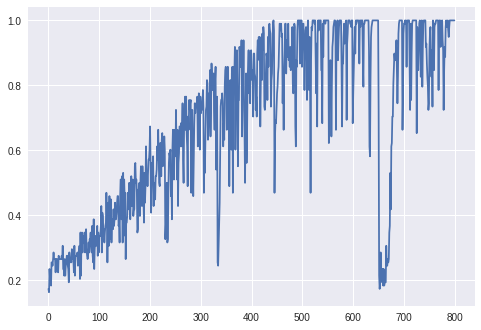

In [68]:
# Plot the accuracy during training
plt.plot(history.history['acc'])

In [69]:
# Evalute the same model
model.evaluate(x=train_x, y=train_y)

98/98 [==============================] - 1s 8ms/step


[0.0036359830968538107, 1.0]